# Convolutional Neural Networks (Part 1): Basics

In this continuation of the series of deep learning tutorials we'll talk about convolutional neural networks, or CNNs. We'll talk about:
- Convolutions: 1D and 2D convolutions, padding, stride, dilation, channels,
- Convolutional layers,
- Pooling layers: max, average, adaptive,
- Basic CNN architectures,
- Training Vanilla AlexNet on Dogs vs Cats

To start, we'll load the same libraries we'll be using. We'll also paste a few functions we've defined in past tutorials so we can continue to use.

This will be the first of these tutorials where it'll be very helpful to run at least parts of this notebook on the GPU, since typical image datasets and models are so big that we wouldn't get anywhere otherwise. 

Note that when using cuda, we need to set a *separate* seed for cuda (the regular torch seed doesn't carry over automatically). We can do this using `torch.cuda.manual_seed(seed)`.

New libraries we'll use in this tutorial are:
- `torchvision`: a subset of pytorch with helpful utilities for working with image datasets, transforms, and models.
- `PIL`: the python library for working with images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T

seed = 54321
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
def lr_find(dataloader, model, opt, loss_fn, batch_size=128, **kwargs):
    from torch_lr_finder import LRFinder
    lr_finder = LRFinder(model, opt, loss_fn, device=device)
    lr_finder.range_test(dataloader, **kwargs)
    lr_finder.plot()
    lr_finder.reset()
    
def num_params(model):
    return sum([p.numel() for p in model.parameters()])

def train_model(train_loader, model, opt, loss_fn, num_epochs, test_loader=None, scheduler=None, show_bar=False,
                score_fn=None):
    losses = []
    for epoch in tqdm(range(num_epochs)):
        # training
        model = model.train()
        train_loss = 0
        iterator = tqdm(train_loader, leave=False) if show_bar else train_loader
        for i, (X, y) in enumerate(iterator):
            X = X.to(device)
            y = y.to(device)
            opt.zero_grad()
            yhat = model(X)
            loss = loss_fn(yhat, y)
            loss.backward()
            opt.step()
            if scheduler is not None:
                scheduler.step()
            losses.append(float(loss))
            train_loss += loss.item()
            if show_bar and i % 10 == 0:
                iterator.set_description(f'(train loss: {round(loss.mean().item(), 3):7.3f})')
        avg_train_loss = round(train_loss / len(train_loader), 5)
        # inference
        if test_loader is not None:
            model = model.eval()
            test_loss = 0
            iterator = tqdm(test_loader, leave=False) if show_bar else test_loader
            for i, (X, y) in enumerate(iterator):
                X = X.to(device)
                y = y.to(device)
                yhat = model(X)
                loss = loss_fn(yhat, y)
                test_loss += loss.item()
            avg_test_loss = round(test_loss / len(test_loader), 5)
        else:
            avg_test_loss = None
        if num_epochs <= 20 or epoch % (num_epochs // 10) == 0:
            string = f'epoch: {epoch} \t train loss: {avg_train_loss:8.5f} \t test loss: {avg_test_loss:8.5f}'
            if score_fn is not None:
                score = get_scores(test_loader, model, loss_fn, score_fn)
                string += f' \t {score_fn.__name__}: {score:8.5f}'
            print(string)
    if not num_epochs <= 20 and not epoch % (num_epochs // 10) == 0:
        string = f'epoch: {epoch} \t train loss: {avg_train_loss:8.5f} \t test loss: {avg_test_loss:8.5f}'
        if score_fn is not None:
            score = get_scores(test_loader, model, loss_fn, score_fn)
            string += f' \t {score_fn.__name__}: {score:8.5f}'
        print(string)
    return model, losses

def get_scores(dataloader, model, loss_fn, score_fn):
    # score_fn must be any valid sklearn scoring function that acts directly on labels
    model = model.eval()
    scores = []
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        yhat = model(X).detach()
        if isinstance(loss_fn, nn.CrossEntropyLoss):
            y_pred = yhat.argmax(dim=-1).long()
        elif isinstance(loss_fn, nn.BCELoss):
            y_pred = yhat.round(dim=-1).long()
        else:
            y_pred = yhat
        score = score_fn(y.flatten().cpu().numpy(), y_pred.flatten().cpu().numpy())
        scores.append(score)
    return sum(scores) / len(scores)

## Data Preprocessing

We'll be working with image data again in this tutorial, particularly, we'll use the well-known Kaggle [Dogs Vs Cats](https://www.kaggle.com/competitions/dogs-vs-cats/overview) dataset, a popular image classification dataset consisting of medium-sized color images of dogs and cats. The goal is to decide whether a given image contains a cat or a dog.


### RGB Images
Just a quick word first though on how images are represented using numerical arrays. Images are typically represented as a matrix of *pixels*, where each pixel is some set of integer values between 0 and 255, where 0=black, 255=white, and values in between are grayscale. If a given image is only one such matrix of shape `(width, height)` it's called *grayscale* (i.e. a black-and-white image). 

If an image consists of *three* matrices stacked together it's called *color*. Each stack is called a *channel*, intended to represent different colors. Usually, the first channel is *red*, the second is *green*, and the third is *blue*. These 3 colors and their shades (0-255) are sufficient to represent *any* color in an image. Such an image is called an *RGB image*. A typical RGB color image (in the standard convention) is an array of shape `(width, height, channels)`. For example, our 227x227 images in this dataset will all have shape `(227, 227, 3)` in standard form.

Unfortunately, pytorch is one of the few exceptions that still doesn't follow the standard convention of `(width, height, channels)`, but instead puts the *channels first* to have a `(channels, width, height)` convention. For example, our 227x227 images will have shape `(3, 227, 227)` in pytorch.

This means that any time we want to plot an image or do image processing (e.g. in numpy or pillow) we have to convert the image to the standard format first, using for example the numpy method `transpose(1, 2, 0)`. Hopefully pytorch will fix this annoyance one day, especially since modern GPUs have been shown to be optimized for the standard channels last image processing.

### Downloading Dogs vs Cats

**Important:** This is a somewhat large dataset of 25k images, taking up about 0.6 GB of disk. Please be aware of this before downloading it and running the cells below. If you do wish to download it, follow the instructions in the cell below to use the kaggle API and get everything configured.

In [5]:
main_path = Path().home() / 'data'
dogs_cats_path = main_path / 'dogs-vs-cats'

if not main_path.exists():
    main_path.mkdir(exist_ok=True)
    
if not dogs_cats_path.exists():
    dogs_cats_path.mkdir(exist_ok=True)

In [6]:
# to download this dataset:
#    - install kaggle API: pip install kaggle
#    - create a kaggle API token in your profile settings
#    - move the downloaded kaggle.json to ~/.kaggle
#    - accept the rules to download at https://www.kaggle.com/competitions/dogs-vs-cats/overview
#    - uncomment and run the lines below
# ! kaggle competitions download -c dogs-vs-cats
# ! mv dogs-vs-cats.zip {dogs_cats_path}
# ! unzip {dogs_cats_path}/dogs-vs-cats.zip
# ! unzip {dogs_cats_path}/train.zip
# ! rm -rf {dogs_cats_path}/*.zip

### Data Processing

Now that we've got the data downloaded, we'll need to figure out how to get it into a pytorch friendly dataset that we can use dataloaders on. Pytorch will allow you to use as a dataset any class that has a `__getitem__` function. This function is what lets you index into an object, e.g. using `dataset[0]`. Outside of this requirement, we have a lot of freedom in how we set up a dataset. For large datasets like this where it's just too much to load it all into memory, it's more convenient for the dataset to point to the file paths instead of actually representing the data directly. The data only gets loaded when we call it using indexing. 

We'll use the python `PIL` package to load each image from memory. We'll also need to transform the images into tensors, resize them, and crop them so that they're all of size 227x227 (we'll see why later).

What about the labels? Different datasets have different conventions for how the labels are annotated. In Dogs vs Cats, the labels are in the *filename* of the image. For example, the filename for an image in the dataset might be `cat.123.jpg`. We can see the label is the first part of the string, which we need to extract and convert into an integer.

We'll do *all* of this inside the `__getitem__` method so that they don't get done when the dataset is instantiated, but when each sample gets called into memory using indexing. This is the best way to handle large datasets, and we'll see it a lot going forward.

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class DogsCatsDataset(Dataset):
    def __init__(self, data_path, filenames, idxs):
        super().__init__()
        self.path = data_path
        self.filenames = [filenames[idx] for idx in idxs]
        self.classes = ['cat', 'dog']
        self.transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(227),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std)
        ])
        
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = PIL.Image.open(self.path / filename)
        label = filename.stem.split('.')[0]
        assert label in ['dog', 'cat']
        x = self.transform(image)
        y = 1 if label == 'dog' else 0
        return x, y
    
    def __len__(self):
        return len(self.filenames)

In [8]:
data_path = dogs_cats_path / 'train'
filenames = [file for file in data_path.iterdir() if file.suffix == '.jpg']

idxs = list(range(len(filenames)))
idxs_train, idxs_test = train_test_split(idxs, random_state=seed, test_size=0.04)

train_data = DogsCatsDataset(data_path, filenames, idxs_train)
test_data = DogsCatsDataset(data_path, filenames, idxs_test)

In [9]:
print(f'training set size: {len(train_data)}')
print(f'test set size: {len(test_data)}')
print(f'image shape (channels first): {train_data[0][0].shape}')
print(f'# classes: {len(train_data.classes)}')
print(f'labels: {train_data.classes}')

training set size: 24000
test set size: 1000
image shape (channels first): torch.Size([3, 227, 227])
# classes: 2
labels: ['cat', 'dog']


In [10]:
def plot_image(image, label=None, mean=mean, std=std, **kwargs):
    image = image.cpu().numpy().transpose(1, 2, 0) * std + mean
    image = np.clip(image, 0, 1)
    plt.figure(figsize=(4, 4))
    plt.imshow(image, **kwargs)
    if label:
        plt.title(f'{label}')
    plt.axis('off')
    plt.show()

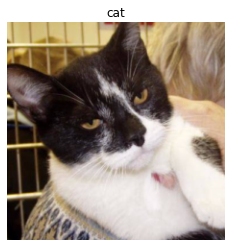

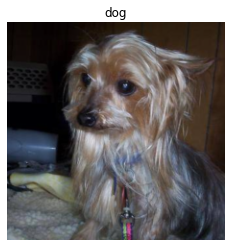

In [11]:
label = None

while label != 'cat':
    idx = np.random.choice(range(len(test_data)))
    image = test_data[idx][0]
    label = test_data.classes[test_data[idx][1]]
plot_image(image, label=label)

while label != 'dog':
    idx = np.random.choice(range(len(test_data)))
    image = test_data[idx][0]
    label = test_data.classes[test_data[idx][1]]
plot_image(image, label=label)

## Convolutions

The most fundamental operation of a CNN is the **convolution**. Before even talking about what a CNN does, or even what a convolutional layer does, we need to understand what the convolution does. Simply put, a convolution can be thought of as sliding a window over an input, where a **kernel** or **filter** operates on the input values inside the sliding window to produce an output value, for every sliding window across the input. In most cases, the operation performed inside each window is an *elementwise multiply* followed by a *sum* to get a single output value.

### 1D Convolutions

Here's an example of a convolution applied to a 1D input using a 1D kernel:
```
input = [1, 2, 3, 4, 5]
kernel = [1, 0, 1]
sliding_windows = [[1, 2, 3], [2, 3, 4], [3, 4, 5]]
output = [sum([1, 2, 3]*[1, 0, 1]), sum([2, 3, 4]*[1, 0, 1]), sum([3, 4, 5]*[1, 0, 1])]
       = [1*1+2*0+3*1, 2*1+0*3+4*1, 3*1+4*0+5*1]
       = [4, 6, 8]
```
In mathematical language, we can express what we just in the following rather unfortunately complicated looking way: Given a 1D input array $X$ of size $n_{in}$ and a 1D kernel $K$ of size $k$, assume their convolution $C$ has size $n_{out}$. The values of $C$ are defined by the operation

$$C[i] \equiv \sum X[i:i+k]\cdot K, \text{ for all }i=0, 1, \cdots, n_{out}-1.$$

The multiplication of the sliding windows $X[i:i+k]$ with the kernel $K$ is done *elementwise*, and the sum is over *all* of the multiplied values in the window. The value of $n_{out}$ is determined by the number of sliding windows, which turns out to be $n_{out}=n_{in}-k+1$.

**Remark:** Unfortunately the convolution operation is defined in slightly different ways by different fields. In fact, the definition of convolution used in deep learning is different from the definition that's used in most of engineering. In the engineering definition of convolution, one first *flips* the *input* left-to-right before applying the above sliding window operation. This flipping operation introduces extra computation though, and doesn't really add anything for learning, so it's almost never used in deep learning.

Notice something interesting. The output of the convolution doesn't usually have the same size as the input. If the input has size $n_{in}$, then the output will have size $n_{out} \equiv n_{in}-k+1$. In our above example, the input had $n_{in}=5$ and $k=3$, so the output would have size $n_{out}=3$, which we saw.

### Padding, Stride, Dilation

This fact that $n_{in} \neq n_{out}$ can be frustrating in practice, because it means if you apply convolutions in sequence (like we will do) that you have to manually keep track of the sizes to make sure nothing breaks. There's a trick to get around this problem, called **padding**. What we'll do is, before applying the convolution, **pad** the ends of the input sequence with a fixed value (usually zero) in such a way that the output size is the same as the input size (before padding).

In most frameworks, using no padding at all is called **valid padding**. Using padding so that $n_{in}=n_{out}$ is called **same padding**. There are also other paddings that are less widely used. In general, when using a padding of size $p$, the output size will become
$$n_{out}=n_{in}-k+1+2p.$$

Let's look at the previous example with same padding. We'll first pad the input size $n_{in}$ with $2p$ values, so that $n_{out}=n_{in}-k+1+2p\equiv n_{in}$. In our above example, we'd add a zero to each side of `input` so that $p=1$, and *then* convolve it with the kernel. We'll then have $n_{in}=5$ and $n_{out}=5$.
```
input = [1, 2, 3, 4, 5]
kernel = [1, 0, 1]
padded_input = [0, 1, 2, 3, 4, 5, 0]
sliding_windows = [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 0]]
output = [sum([0, 1, 2]*[1, 0, 1]), sum([1, 2, 3]*[1, 0, 1]), ..., sum([4, 5, 0]*[1, 0, 1])]
       = [0*1+1*0+2*1, 1*1+2*0+3*1, 2*1+0*3+4*1, 3*1+4*0+5*1, 4*1+5*0+0*1]
       = [2, 4, 6, 8, 4]
```

There are also two other sometimes used operations to be aware of that tweak the convolution somewhat: strides and dilations.

**Stride:** Suppose we wanted to convolve a window over the input, but instead of convolving over *every* input we just want to convolve over every other input, or every third input, etc. We can do this using a stride. All we need to do is skip steps by jumping a step size $s$ (called the **stride**) as we convolve the window. Not skipping steps at all would mean taking a stride of 1, or $s=1$. Skipping every other input would be a stride $s=2$. Etc.

Here's an example using the same input and kernel, but with a stride of 2 a same padding. We'd have
```
padded_input = [0, 1, 2, 3, 4, 5, 0]
kernel = [1, 0, 1]
sliding_windows_stride_2 = [[0, 1, 2], [2, 3, 4], [4, 5, 0]]
output = [sum([0, 1, 2]*[1, 0, 1]), sum([2, 3, 4]*[1, 0, 1]), sum([4, 5, 0]*[1, 0, 1])]
       = [2, 6, 4]
```
Since we're skipping inputs, using a stride will cause the output to have fewer values by a factor of $s$, so
$$n_{out} = 1 + \big(n_{in}-k+2p \big) \big/\big/ s.$$

**Dilation:** We saw that padding is one way to expand the size of the input. Padding works by inserting spacing along the ends or *boundary* of the input. Another thing we could do is insert spacing *between* each input values. This is called **dilation**. Dilation works by inserting $d-1$ spacing values between each interior input value. Using no dilation at all (inserting no spaces) means $d=1$. 

Here's an example using the same input and kernel, but with a dilation of 2, no stride, and valid padding. We'd have
```
input = [1, 2, 3, 4, 5]
dilated_input = [1, 0, 2, 0, 3, 0, 4, 0, 5]
kernel = [1, 0, 1]
sliding_windows = [[1, 0, 2], [0, 2, 0], [2, 0, 3], [0, 3, 0], [3, 0, 4], [0, 4, 0], [4, 0, 5]]
output = [sum([1, 0, 2]*[1, 0, 1]), sum([0, 2, 0]*[1, 0, 1]), ..., sum([4, 0, 5]*[1, 0, 1])]
       = [3, 0, 5, 0, 7, 0, 9]
```
Adding dilation to the mix along with padding and stride will make the most general output size look like
$$n_{out} = 1 + \big(n_{in}+(1-k)d+2p-1 \big) \big/\big/ s.$$

**Remark:** It can be kind of complicated to think about what exactly a convolution is doing to an input, especially when stride and dilation are involved. See this [page](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) for a plot of some visuals to help you picture what's going on. They're showing what 2D convolutions look like on images, instead of 1D convolutions on sequences. We'll get to the 2D version soon, but there's very little difference.

### Implementing Convolutions

Let's go ahead and write a function `conv1d` that can convolve a 1D input sequence with a 1D kernel, allowing for the possibility of padding, stride, and dilation. The only paddings we'll consider are valid and same padding. We'll then apply this function to our examples above to make sure the desired output reproduces itself.

In [12]:
def conv1d(input, kernel, padding='valid', stride=1, dilation=1):
    k = len(kernel)
    # set the padding value p st len(input) == len(output) if 'same'
    p = (k - 1) // 2 if padding == 'same' else 0
    # expand the input by the dilation and padding factors
    expanded_input = [x_new for x in input[:-1] for x_new in [x] + [0] * (dilation - 1)] + [input[-1]]
    expanded_input = [0] * p + expanded_input + [0] * p
    expanded_input = torch.tensor(expanded_input)
    n_expanded = len(expanded_input)
    n_out = 1 + (len(input) + (1 - k) * dilation + 2 * p - 1) // stride
    # convolve the kernel over the input with a given stride
    output = []
    for i in range(0, n_out, stride):
        window = expanded_input[i: i + k]
        output.append((window * kernel).sum())
    return torch.tensor(output)

In [13]:
X = torch.tensor([1, 2, 3, 4, 5]).float()
K = torch.tensor([1, 0, 1]).float()

In [14]:
conv1d(X, K, padding='valid')

tensor([4., 6., 8.])

In [15]:
conv1d(X, K, padding='same')

tensor([2., 4., 6., 8., 4.])

Here are a couple of examples using stride and dilation.

In [16]:
conv1d(X, K, padding='valid', stride=2, dilation=1)

tensor([4.])

In [17]:
conv1d(X, K, padding='valid', stride=1, dilation=2)

tensor([3.])

Of course, we don't have to actually implement convolution ourselves. Good thing, because doing so can be very error-prone and very computationally inefficient. Pytorch implements our `conv1d` function with `F.conv1d`, which takes basically the same arguments, but works much more efficiently than our implementation. One subtlety with the pytorch implementation however is that it expects the input and kernel to be shaped in a particular way. Namely, the input takes shape `(batch_size, input_channels, input_size)` and the kernel takes shape `(output_channels, input_channels, input_size)`. In our example, the input and output channels are both just 1, as well as the batch size since there's only one example being passed in. We'll deal with more channels and examples soon.

In [18]:
X = X[None, None, :]
K = K[None, None, :]
X.shape, K.shape

(torch.Size([1, 1, 5]), torch.Size([1, 1, 3]))

In [19]:
F.conv1d(X, K, padding='valid')

tensor([[[4., 6., 8.]]])

In [20]:
F.conv1d(X, K, padding='same')

tensor([[[2., 4., 6., 8., 4.]]])

### 2D Convolutions

Now that we have an understanding of 1D convolutions, upgrading to 2D convolutions for images is pretty simple. The only difference is we now convolve a 2D kernel across a 2D input instead of a 1D window across a 1D sequence. 

Again, the math can look a little bit confusing, but it's the same thing as for 1D except with a new dimension that also convolves too. Suppose the input matrix $X$ has size $h_{in}\times w_{in}$ (height by width), the kernel $K$ has size $k \times k$, and their convolution $C$ has size $h_{out}\times w_{out}$. Then the values of $C$ are given by
$$
C[i,j] = \sum X[i:i+k,\; j:j+k] \cdot K, \text{ for all } 
\begin{cases}
i = 0, 1,\cdots,w_{out}-1, \\
j = 0, 1,\cdots,h_{out}-1.
\end{cases}
$$

The sliding window $X[i:i+k,\; j:j+k]$ times the kernel $K$ is assumed to be *elementwise*, and the sum is over all values in the window.

The output sizes $h_{out}, w_{out}$ come from the same formulas as above for the 1D case depending on whether padding, stride, or dilation are used. For example, in the simple case with valid padding and no stride or dilation, we just get
$$h_{out}=h_{in}-k+1,$$
$$w_{out}=w_{in}-k+1.$$

Implementating a function `conv2d` works exactly the same as `conv1d`, except we have to iterate over *both* the rows and columns of the input image. Unfortunately, implementing the padding, stride, and dilation can be more of a pain in the ass, so we'll just implement a simple version with none of these. We'll use a 3x3 kernel, which should mean that both the height and width of the input image get reduced from 227 to 227-3+1=225, which they do.

In [21]:
def conv2d(input, kernel):
    k = len(kernel)
    w = input.shape[0]
    h = input.shape[1]
    w_out = w - k + 1
    h_out = h - k + 1
    output = []
    for i in range(0, w_out):
        row = []
        for j in range(0, h_out):
            window = input[i: i + k, j: j + k]
            row.append((window * kernel).sum())
        output.append(row)
    return torch.tensor(output)

In [22]:
X = train_data[-10][0].mean(dim=0).float()
K = torch.tensor([[1, 0, -1], [1, 0, -1], [1, 0, -1]]).float()
X.shape, K.shape

(torch.Size([227, 227]), torch.Size([3, 3]))

In [23]:
C = conv2d(X, K)
C.shape

torch.Size([225, 225])

Just out of curiosity, let's go ahead and plot what the output `C` looks like. Since it's a (grayscale) image, we can plot with the above `plot_image` function as long as we remember to insert a channel at the beginning and not pass in the channel `mean` and `std` vectors from above (e.g. just using mean 0 and std 1 is simplest).

The first image shown is `X`, which is just a grayscaled version of the original image (gotten by averaging over the channels dimension). The second image is the filtered output `C`. Notice what the kernel `K` in this particular case appears to be doing. It appears it detects vertical edges in the input image, as those are the features that get emphasized in the output. There are many *edge filters* in computer vision, of which our choice of `K` is one of the simpler ones.

The plots tell us something interesting about what convolution is doing to inputs. We can think of them as extracting certain kinds of features from the input. In this case, those features are vertical edges in an image. This *feature extraction* tendency is one of the things that makes convolutions so powerful in deep learning.

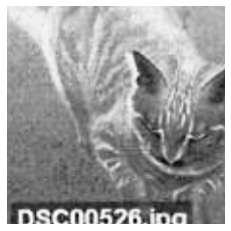

In [24]:
plot_image(X[None, :], mean=np.mean(mean), std=np.mean(std), cmap='Greys')

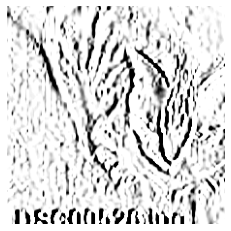

In [25]:
plot_image(C[None, :], mean=0, std=1, cmap='Greys')

We can implement `conv2d` in pytorch using `F.conv2d`. Their implementation is faster, and allows for the use of padding, stride, and dilation. Similar to `F.conv1d`, we have to first expand the input and kernel by adding in channels. Here's an example using same padding on the above image with the same vertical edge filter.

In [26]:
X = X[None, None, :]
K = K[None, None, :]
C = F.conv2d(X, K, padding='same')
X.shape, K.shape, C.shape

(torch.Size([1, 1, 227, 227]),
 torch.Size([1, 1, 3, 3]),
 torch.Size([1, 1, 227, 227]))

### Convolution with Multiple Channels

How does convolution work if we have input channels, e.g. like with color images or stereo audio clips? Exactly the same way, except that the sliding window now includes *all input channels*. For a 1D sequence like audio, that means that the sliding window is now a 2D operation sliding across all channels simultaneously. For a 2D sequence like video, it means the sliding window is now a 3D operation sliding across all channels simultaneously. The elementwise multiply is done over *all* values in this larger sliding window, and the sum operation sums them all together to still produce a single value per window like before. This means, for example, that even if the input has $c_{in}$ channels, if it is convolved with a *single* size $k$ (or $k\times k$) filter, the output will only have one channel $c_{out}=1$. 

What if we want multiple output channels though, as in CNNs we definitely will? What we can do is just convolve the input $\boldsymbol{X}$ with $c_{out}$ different kernels $\boldsymbol{K}=(K_1,\cdots,K_{c_{out}})$ and stack the results together to get the output $\boldsymbol{C}=(C_1,\cdots,C_{c_{out}})$. Here's an example of what $\boldsymbol{C}$ will look like in the 1D case.

$$\boldsymbol{C}[:,\: i] = \sum \boldsymbol{X}[:,\: i:i+k]\cdot \boldsymbol{K}, \text{ for all }i=0,1,\cdots,n_{out}-1.$$

Notice that the *only* difference between this formula and the one for the regular 1D convolution is the addition of the colon $:$ in dimension 0. That's the channel dimension (at least in the pytorch convention). We're now summing over *all* values in the window across *all* channels.

Here's an example of what convolving over multiple channels looks like for a 1D input with 2 input channels and 2 output channels, with no stride, dilation, or padding.
```
input_channel_1 = [1, 2, 3, 4, 5]
input_channel_2 = [-1, -1, -2, -2, -3]
kernel_1 = [1, 0, 1]
kernel_2 = [2, 0, 2]
sliding_windows = [[[1, 2, 3], [-1, -1, -2]],
                   [[2, 3, 4], [-1, -2, -2]],
                   [[3, 4, 5], [-2, -2, -3]]]
output_channel_1 = [sum([[1, 2, 3]*[1, 0, 1], [-1, -1, -2]*[1, 0, 1]]),
                    sum([[2, 3, 4]*[1, 0, 1], [-1, -2, -2]*[1, 0, 1]]),
                    sum([[3, 4, 5]*[1, 0, 1], [-2, -2, -3]*[1, 0, 1]])]
                 = [1, 3, 3]
output_channel_2 = [sum([[1, 2, 3]*[2, 0, 2], [-1, -1, -2]*[2, 0, 2]]),
                    sum([[2, 3, 4]*[2, 0, 2], [-1, -2, -2]*[2, 0, 2]]),
                    sum([[3, 4, 5]*[2, 0, 2], [-2, -2, -3]*[2, 0, 2]])]
                 = [2, 6, 6]
```
The extention of this definition to the 2D case is exactly like you'd expect, with the extra dimension being convolved over like 

$$\boldsymbol{C}[:,\: i,\: j] = \sum \boldsymbol{X}[:, i:i+k,\: j:j+k]\cdot \boldsymbol{K}.$$

Below is the same cat image example as before, except we use the 3-channel RGB image instead of the grayscale version. We'll also go ahead and use 2 kernels, the same vertical edge filter, and a new horizontal edge filter. This will give an output that has 2 channels, with the first being the vertical edge features and the second being the horizontal edge features.

In [27]:
X = train_data[-10][0].float()
K_vert = [[1, 0, -1], [1, 0, -1], [1, 0, -1]]
K_hor = [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]
K = torch.tensor([[K_vert] * 3, [K_hor] * 3]).float()
X.shape, K.shape

(torch.Size([3, 227, 227]), torch.Size([2, 3, 3, 3]))

In [28]:
C = F.conv2d(X, K, padding='same')
C.shape

torch.Size([2, 227, 227])

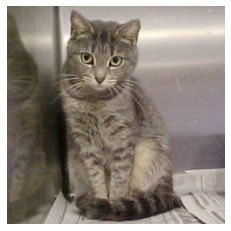

In [29]:
plot_image(X)

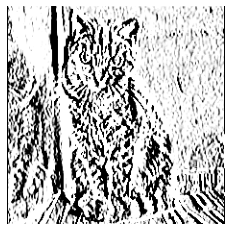

In [30]:
plot_image(C[0, :][None, :], mean=0, std=1, cmap='Greys')

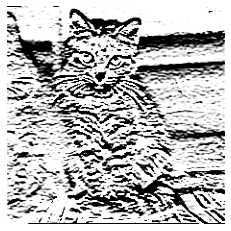

In [31]:
plot_image(C[1, :][None, :], mean=0, std=1, cmap='Greys')

## Convolutional Layers

Now that we've discussed how the fundamental convolution operation works we can discuss how it's used to create neural networks. Convolution is mainly used to implement convolutional layers. A **convolutional layer** is a layer of the form
$$\boldsymbol{Z} = \boldsymbol{K} \ast \boldsymbol{X} + \boldsymbol{b}.$$
It looks exactly like a linear layer, except that instead of *matrix multiplying* the inputs $\boldsymbol{X}$ by a weight matrix $\boldsymbol{W}$, we *convolve* $\boldsymbol{X}$ with a set of kernels $\boldsymbol{K}$. The bias vector $\boldsymbol{b}$ works exactly the same way as for linear layers.

A neural network that uses convolutional layers instead of linear layers (at least some of the time) is called a **convolutional neural network**.

The kernels $\boldsymbol{K}$ have values that will now be *learned* instead of being manually created like we did above with the edge filters. This is part of what gives CNNs their power. They can learn what the appropriate filters are to understand the input (e.g. so it can classify an image).

The shapes of these tensors depend on whether we're using 1D or 2D convolution:
- 1D Convolution: If $\boldsymbol{X}$ and has shape $(c_{in},n_{in})$ and $\boldsymbol{K}$ has shape $(c_{out}, c_{in}, k)$, then the output $\boldsymbol{Z}$ will have shape $(c_{out},n_{out})$.
- 2D Convolution: If $\boldsymbol{X}$ and has shape $(c_{in},w_{in},h_{in})$ and $\boldsymbol{K}$ has shape $(c_{out}, c_{in}, k, k)$, then the output $\boldsymbol{Z}$ will have shape $(c_{out},w_{out},h_{out})$.

The outputs of a convolutional layer are treated pretty much the same way as the outputs of a linear layer. We can pass them through activation function $f$ to get activations (neurons) $\boldsymbol{A} = f(\boldsymbol{Z})$. We can also pass them through normalization layers or apply dropout.

In pytorch we can create convolutional layers using `nn.Conv1d` and `nn.Conv2d`, depending which one we wish to use. The order of arguments passed into the layer should always be $(c_{in}, c_{out}, k)$, or in code `(in_channels, out_channels, kernel_size)`. Just like the functions `F.conv1d` and `F.conv2d`, these layers also take arguments for the padding, stride, and dilation of the convolution operation.

Here's the same image example from above, but using a `nn.Conv2d` layer instead.

In [32]:
X = train_data[1][0].float()

layer = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, padding='same', stride=1, dilation=1)
Z = layer(X)

X.shape, Z.shape, layer.weight.shape, layer.bias.shape

(torch.Size([3, 227, 227]),
 torch.Size([2, 227, 227]),
 torch.Size([2, 3, 3, 3]),
 torch.Size([2]))

## Pooling Layers


CNNs usually contain another unique type of layer called a **pooling layer**. Pooling layers act to shrink the size of the input along the height and/or width dimensions. These layers typically don't have parameters, acting only to shrink the input size.

The way pooling layers shrink the input size is using the same sliding windows approach that convolution uses. We slide a window of kernel size $k$ across the input. Each window is used to calculate a single output value depending on what type of pooling operation is used. Stride, padding, and dilation can also be used. 

The two most common pooling operations are **max pooling** and **average pooling**. For max pooling, the output value of each sliding window is the *max* of values in that window. For average pooling, the output value of each sliding window is the *mean* of values in that window.

To see how pooling works, let's again consider a simple 1D example using *max pooling* with a size 2 kernel, no padding, and stride 2. By design, the output size is *halved*, a pretty common design choice for pooling layers.
```
input = [1, 2, 3, 4, 5, 6]
sliding_windows_stride_2 = [[1, 2], [3, 4], [5, 6]]
output = [max(1, 2), max(3, 4), max(5, 6)]
       = [2, 4, 6]
```

The mathematical formula for the pooling layer can be written something like the following. Suppose again we have a 1D input $\boldsymbol{X}$ with size $n_{in}$ and an output $\boldsymbol{C}$ with size $n_{out}$. Again, there is no kernel in pooling layers. We then have

$$\boldsymbol{C}[:,\: i] = \text{pool}\big(\boldsymbol{X}[:,\: i:i+k]\big), \text{ for all }i=0,1,\cdots,n_{out}-1.$$

The pooling function $\text{pool}$ can be any reducing function. For max pooling, $\text{pool}=\text{max}$. For average pooling, $\text{pool}=\text{mean}$.

An important distinction between pooling and convolution is in the channels. While convolution acts on all channels at once, pooling slides a window over each channel individually. This means $c_{in}=c_{out}$ always for pooling layers.

Pooling works exactly the same with images and other 2D data, except using 2D windows instead. In the above example with a size 2 kernel, no padding, and stride 2, *both* the height and width of the image will shrink by half. Let's see what that looks like using the pytorch `F.max_pool2d` function, which implements the 2D max pooling operation. We can see that along each channel the height and width get halved from 227 to 113.

A plot of what the output of applying this max pooling to an image is also shown. Plotting `X` and `Y`, if you look carefully you can see that `Y` is grainer than `X`, an indication that its size was shrunk a decent bit.

In [33]:
X = train_data[5][0].float()
Y = F.max_pool2d(X, kernel_size=2, stride=2, padding=0)
X.shape, Y.shape

(torch.Size([3, 227, 227]), torch.Size([3, 113, 113]))

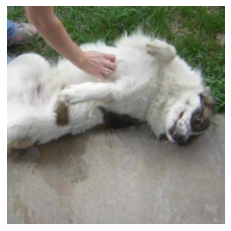

In [34]:
plot_image(X, mean=mean, std=std)

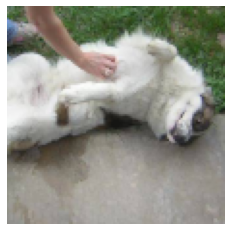

In [35]:
plot_image(Y, mean=mean, std=std)

We can create pooling layers in pytorch using:
- 1D: `nn.MaxPool1d` for max pooling, `nn.AvgPool1d` for average pooling.
- 2D: `nn.MaxPool2d` for max pooling, `nn.AvgPool2d` for average pooling.

In [36]:
layer = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
Y = layer(X)
X.shape, Y.shape

(torch.Size([3, 227, 227]), torch.Size([3, 113, 113]))

In [37]:
layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
Y = layer(X)
X.shape, Y.shape

(torch.Size([3, 227, 227]), torch.Size([3, 113, 113]))

I'll finish this section by mentioning that there are actually *better* implementations of pooling called **adaptive pooling**. Rather than forcing us to fiddle with kernel sizes, stride, and padding to make the output sizes come out the way we'd like, adaptive pool lets us pre-specify what output size we want to have. This ensures that we can use pooling to map *any* input size to *any* output size (as long as the output size is smaller than the input size). This fact becomes very handy when designing CNNs so they don't break due to annoying shape mismatch errors. 

Adaptive pooling comes in the same two variants, max and average, implemented in pytorch using:
- 1D: `nn.AdaptiveMaxPool1d` for max pooling, `nn.AdaptiveAvgPool1d` for average pooling.
- 2D: `nn.AdaptiveMaxPool2d` for max pooling, `nn.AdaptiveAvgPool2d` for average pooling.

Here's an example. Suppose for some reason we want to map our 227x227 input to a 100x100 output using max pooling.

In [38]:
layer = nn.AdaptiveMaxPool2d(output_size=100)
Y = layer(X)
X.shape, Y.shape

(torch.Size([3, 227, 227]), torch.Size([3, 100, 100]))

## CNNs

We've now discussed all the key building blocks necessary to build a simple CNN. Let's now mention some general design principles of a CNN, in this case applied to image classification. Many of the basic design principles of CNNs are based on a few classic CNN architectures that are rarely used in practice anymore: LeNet-5, AlexNet, and VGG-16. 

Some general CNN design principles that came out of those earlier architectures are:
- The height and width of inputs should generally *decrease* the deeper the network gets.
- The number of channels should generally *increase* the deeper the network gets.
- Torwards the "end" of the network, convolutional layers should be flattened and turned into a sequence of linear layers.
- A basic CNN used for input classification (or regression) will generally look something like: $$\text{Input} \rightarrow \big(\text{Conv} \rightarrow \text{ReLU} \rightarrow \text{Pool}\big)^N \rightarrow \text{Flatten} \rightarrow \big(\text{Linear} \rightarrow \text{ReLU}\big)^M \rightarrow \text{Output},$$ where $N$ and $M$ are the number of times the given block repeats (usually 3 or more times each).
- Normalization and dropout layers can be added as with other neural networks.
- Batch norm is typically the most commonly used normalization layer for CNNs.

### AlexNet

Here's an example of such an architecture. We'll implement AlexNet from scratch. AlexNet was the result of perhaps the most important [paper](https://proceedings.neurips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) ever in deep learning. Released in 2012, AlexNet was an image classifier built to classify the ImageNet dataset for a competition going on at the time. The fact that AlexNet was able to do so much better at classifying those images than the other (classical) approaches was what helped deep learning take off and start becoming the singular big thing in AI that it is today.

<img src=https://miro.medium.com/max/1400/1*3B8iO-se13vA2QfZ4OBRSw.png width=600>

Above is a figure illustrating what the AlexNet architecture looks like. AlexNet takes in input color images of size 227x227, i.e. inputs of shape `(batch_size, 3, 227, 227)` in pytorch. The output is then a sequence of either logits or softmax probabilities of shape `(batch_size, 1000)`. Since the ImageNet dataset has 1000 classes, the output size is 1000. For other classification problems we'd want to change this number by using a variable `out_features` to determine the size of the output layer.

The inside of AlexNet largely follows the CNN design paradigm I described above. The main difference is that it doesn't use max pooling after *every* convolutional layer. But the same principles hold. 
- The channels (mostly) increase from left to right: `3, 96, 256, 384, 256, 9216, 4096`. 
- The heights and widths shrink from left to right: `227, 55, 27, 13, 6, 1`.
- Convolutional blocks in the early layers and linear (fully connected) blocks in the later layers.

Here's an implementation of AlexNet that allows for an arbitrary number of output classes. Other than the output layer, everything else is exactly the same. as in the above figure. We'll go ahead and use an output size `out_features=2` since we just have a 2 classes in Dogs vs Cats. Notice that in loading the data we already resized the input images already so that they are 227x227.

In [39]:
out_features = len(train_data.classes)

def alex_net(out_features):
    model = nn.Sequential(
        # (3, 227, 227) -> (96, 55, 55)
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding='valid'),
        nn.ReLU(inplace=True),
        # (96, 55, 55) -> (96, 27, 27)
        nn.MaxPool2d(kernel_size=3, stride=2),
        # (96, 27, 27) -> (256, 27, 27)
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),
        nn.ReLU(inplace=True),
        # (256, 27, 27) -> (256, 13, 13)
        nn.MaxPool2d(kernel_size=3, stride=2),
        # (256, 13, 13) -> (384, 13, 13)
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(inplace=True),
        # (384, 13, 13) -> (384, 13, 13)
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(inplace=True),
        # (384, 13, 13) -> (256, 13, 13)
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(inplace=True),
        # (256, 13, 13) -> (256, 6, 6)
        nn.MaxPool2d(kernel_size=3, stride=2),
        # (256, 6, 6) -> 9216
        nn.Flatten(),
        nn.Dropout(p=0.5),
        # 9216 -> 4096
        nn.Linear(in_features=9216, out_features=4096),
        nn.ReLU(inplace=True),
        # 4096 -> 4096
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(inplace=True),
        # 4096 -> out_features
        nn.Linear(in_features=4096, out_features=out_features)
    )
    return model

model = alex_net(out_features)

In [40]:
num_params(model) / 1_000_000

58.289538

AlexNet contains almost 58.3M parameters, which is a bit bigger than any neural nets we've worked with so far. It's at this point where it becomes very helpful to use the GPU, especially for model training.

When you create a complex model like this it's always a good idea to test it on an input in your dataset to make sure that the shapes come out right. In this case, we should pass input tensors of shape `(N, 3, 227, 227)` into the model and get out output tensors of shape `(N, 37)`. Very often you'll get errors at this stage if you've defined something in your model wrong, and you can use this test to correct those issues early.

In [41]:
X = train_data[0][0][None, :]
X.shape, model(X).shape

(torch.Size([1, 3, 227, 227]), torch.Size([1, 2]))

### Why CNNs Work

It's an interesting question to ask *why* CNNs work for many deep learning tasks, especially tasks dealing with continuous input data like images or audio. CNNs are believed to be powerful for a few reasons:
- **Parameter Sharing:** Perhaps the most useful property of a convolutional layer is that it uses far fewer parameters than a linear layer to extract features from an input. For example, suppose we took our `(3, 227, 227)` images and passed them through a linear layer of size `(96, 55, 55)`. Then the weights in the linear layer would have an astounding `(3*227*227) * (96*55*55) = 44,892,064,800 = 44.9B` parameters! That's already *way* bigger than our AlexNet model of 58.3M parameters across the *entire* network. But if we use a convolutional layer instead of a linear layer in the first layer, we only get `96 * (3*11*11+1) = 34,944 = 35k` parameters. That's *far* fewer parameters, yet still able to extract relevant features from an image.
- **Spatial Locality:** Since convolutions involve sliding windows over the data, they make use of *spatial locality* in the input. This refers to the fact that values in an input that are near each other should be similar to each other. Consider an image, for example. It's very likely in an image that for any given pixel, the pixels right next to it in the image are the most important to look at to decide what that pixel is doing. Convolutions allow us to make use of this fact, as the sliding windows will look at those nearby pixels, but ignore the ones farther away.
- **Translation Invariance:** Given something like an image or a clip of audio, it should be true that if we slightly shift the entire input a little bit then the *label* of that input won't change. If we take an image of a cat and shift every pixel a little bit to the left, it's still an image of a cat. This is *translational invariance*. CNNs are believed to have this property built in due partly to the pooling layers. If we use, for example, max pooling on an image, we reduce the size of the image. If that image was shifted just a little bit, max pooling should be invariant to that fact and produce the same output. This makes CNNs more robust to shifts in the data than, say, an MLP.

### Example: Training AlexNet on Dogs vs Cats

Let's try to train the AlexNet on the Dogs vs Cats and see how well we can do. Since the images are pretty large, we'll need to use a smaller batch size than we might prefer to avoid running out of GPU memory. I'll choose 16, though we could possibly get away with 32 or even 64. Since this is still a relatively small image dataset, we'll see that AlexNet can easily overfit the data. Thus we'll need to use a little bit of weight decay as well.

**Important:** I wouldn't run this code unless you're using a GPU. It will be ungodly slow if you don't. It should take about 1 minute per epoch on a half decent NVIDIA GPU, so about 20 minutes to fully train. If you're on a CPU it'll be much, much slower, and you should probably skip running this section and just read along.

In [42]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

In [43]:
model = alex_net(out_features)
model = model.to(device)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-04


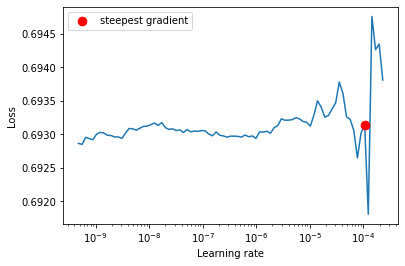

In [44]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
lr_find(train_loader, model, opt, loss_fn, batch_size=batch_size, start_lr=1e-10, end_lr=5e-4)

In [45]:
num_epochs = 20
lr = 1e-4
weight_decay = 1e-5

opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=lr, epochs=num_epochs, pct_start=0.3,
                                                steps_per_epoch=len(train_loader))
loss_fn = nn.CrossEntropyLoss()
model, losses = train_model(train_loader, model, opt, loss_fn, num_epochs, test_loader=test_loader,
                            scheduler=scheduler, show_bar=False, score_fn=accuracy_score)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 	 train loss:  0.63534 	 test loss:  0.59082 	 accuracy_score:  0.70437
epoch: 1 	 train loss:  0.53734 	 test loss:  0.46543 	 accuracy_score:  0.77282
epoch: 2 	 train loss:  0.44010 	 test loss:  0.39340 	 accuracy_score:  0.82044
epoch: 3 	 train loss:  0.35903 	 test loss:  0.36411 	 accuracy_score:  0.82440
epoch: 4 	 train loss:  0.28996 	 test loss:  0.33262 	 accuracy_score:  0.86210
epoch: 5 	 train loss:  0.24443 	 test loss:  0.23273 	 accuracy_score:  0.89881
epoch: 6 	 train loss:  0.20318 	 test loss:  0.20125 	 accuracy_score:  0.90476
epoch: 7 	 train loss:  0.17043 	 test loss:  0.26017 	 accuracy_score:  0.87798
epoch: 8 	 train loss:  0.13938 	 test loss:  0.19857 	 accuracy_score:  0.92063
epoch: 9 	 train loss:  0.10975 	 test loss:  0.18361 	 accuracy_score:  0.91964
epoch: 10 	 train loss:  0.08082 	 test loss:  0.21153 	 accuracy_score:  0.91964
epoch: 11 	 train loss:  0.05979 	 test loss:  0.30642 	 accuracy_score:  0.91270
epoch: 12 	 train loss:  0

In [46]:
print(f'train accuracy: {get_scores(train_loader, model, loss_fn, accuracy_score)}')
print(f'test accuracy: {get_scores(test_loader, model, loss_fn, accuracy_score)}')

train accuracy: 1.0
test accuracy: 0.9325396825396826


Evidently, given an image, we can now classify whether it contains a cat or dog with around 93.3% accuracy! Is this good or bad? It doesn't seem too bad. If you look at the kaggle leaderboard for this competition though, you'll see that the top 50 scores were 96-98% accuracy, and that was 8 years ago. We should be able to do better on this dataset. 

In the next CNN tutorial we'll see some more advanced architectures, as well as a new and very important concept called **transfer learning**. Those two things together will allow us to get to 99% test set accuracy on this dataset, with less training!